In [35]:

import math
import numpy as np
import bisect
from scipy import interpolate
import pylab as pl

class Spline:
    """
    Cubic Spline class
    """
    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x
        h = np.diff(x)
        # calc coefficient c
        self.a = [iy for iy in y]
        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)
        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)
    def calc(self, t):
        """
        Calc position

        if t is outside of the input x, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """
        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class

    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        if yaw<0:
            yaw = yaw+2*math.pi
        return yaw



def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


Spline 2D test


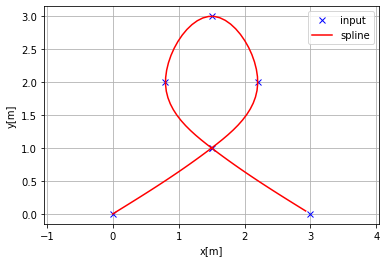

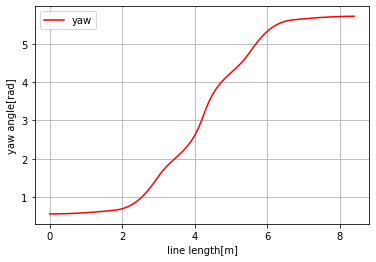

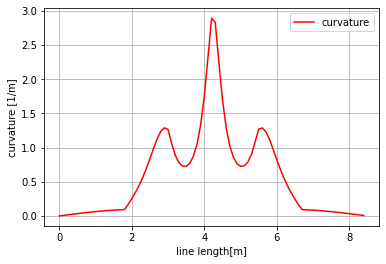

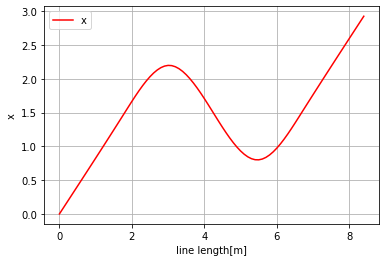

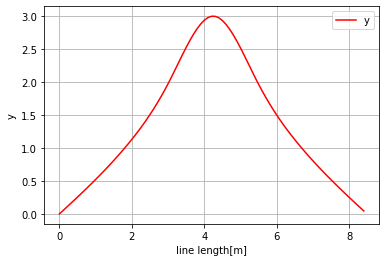

85


In [37]:

print("Spline 2D test")
import matplotlib.pyplot as plt
#     x = [0, 1.5，1.5，1.5 3, 5.0, 7.5, 3.0, -1.0]
#     y = [0, 1.2,  3, , 0.0, 5.0, -2.0]
x = [0,  1.5,  2.2,  1.5, 0.8, 1.5,  3]
y = [0,  1,     2,    3,   2, 1,   0]
ds = 0.1  # [m] distance of each intepolated points

sp = Spline2D(x, y)
s = np.arange(0, sp.s[-1], ds)
#     s = np.linespace()

rx, ry, ryaw, rk = [], [], [], []
for i_s in s:
    ix, iy = sp.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    ryaw.append(sp.calc_yaw(i_s))
    rk.append(sp.calc_curvature(i_s))

plt.subplots(1)
plt.plot(x, y, "xb", label="input")
plt.plot(rx, ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()

plt.subplots(1)
plt.plot(s, [iyaw for iyaw in ryaw], "-r", label="yaw")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("yaw angle[rad]")

plt.subplots(1)
plt.plot(s, rk, "-r", label="curvature")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("curvature [1/m]")


plt.subplots(1)
plt.plot(s, rx, "-r", label="x")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("x")


plt.subplots(1)
plt.plot(s, ry, "-r", label="y")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("y")

plt.show()
print(len(ryaw))




cubic


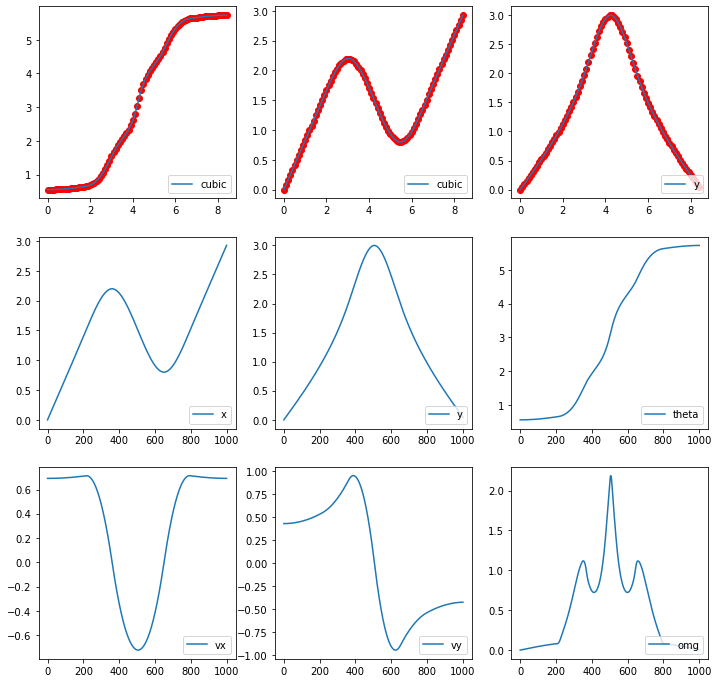

In [40]:
plt.figure(figsize=[12,12])
xnew=np.linspace(0,s[-1],1001)
plt.subplot(3,3,1)
plt.plot(s,ryaw,'ro')
list1=['cubic']
list2=[3]
kind = 'cubic'
print(kind)
fyaw=interpolate.interp1d(s,ryaw,kind=kind)
yawnew=fyaw(xnew)
plt.plot(xnew,yawnew,label=kind)

plt.legend(loc='lower right')


plt.subplot(3,3,2)
fx = interpolate.interp1d(s,rx,kind=kind)
plt.plot(s,rx,'ro')
x_new_=fx(xnew)
plt.plot(xnew,x_new_,label=kind)
plt.legend(loc='lower right')



plt.subplot(3,3,3)
fy= interpolate.interp1d(s,ry,kind=kind)
plt.plot(s,ry,'ro')
ynew_=fy(xnew)
plt.plot(xnew,ynew_,label="y")
plt.legend(loc='lower right')

plt.subplot(3,3,4)
plt.plot(x_new_,label="x")
plt.legend(loc='lower right')

plt.subplot(3,3,5)
plt.plot(ynew_,label="y")
plt.legend(loc='lower right')

plt.subplot(3,3,6)
plt.plot(yawnew,label="theta")
plt.legend(loc='lower right')

vx = x_new_[1:]-x_new_[:-1]
vx = np.concatenate([[vx[0]],vx])/0.01
vy = ynew_[1:]-ynew_[:-1]
vy = np.concatenate([[vy[0]],vy])/0.01
omg = yawnew[1:]-yawnew[:-1]
omg = np.concatenate([[omg[0]],omg])/0.01

plt.subplot(3,3,7)
plt.plot(vx,label="vx")
plt.legend(loc='lower right')

plt.subplot(3,3,8)
plt.plot(vy,label="vy")
plt.legend(loc='lower right')

plt.subplot(3,3,9)
plt.plot(omg,label="omg")
plt.legend(loc='lower right')

plt.show()

In [41]:
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import quadrotor
import math



robot = quadrotor.Quadrotor()
horizon_length = 1000
N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10
middle = 500
tau = 0.6


yawnew = np.array(yawnew)
omg = np.array(omg)



state_desired = np.array([x,vx,y,vy,yawnew,omg])



In [76]:
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import quadrotor
import math



robot = quadrotor.Quadrotor()
horizon_length = 1000
N = 1000
u_ = robot.mass*robot.g/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10
middle = 500
tau = 0.6
x = np.array(x_new_)
vx = np.array(vx)
y = np.array(ynew_)
vy = np.array(vy)
yawnew = np.array(yawnew)
omg = np.zeros(len(omg))
# omg = np.array(omg)
state_desired = np.array([x,vx,y,vy,yawnew,omg])



In [77]:
ref_traj = state_desired.T
z0 = np.zeros_like(state_desired[:,0])
u_init = [(robot.mass * robot.g / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np

class iLQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.ilqr_ = None

        self.use_autograd=use_autograd
        return

    def build_iLQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x - self.ref_array[t]
            #autograd does not allow A.dot(B)
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.ilqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                   use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:obj.next_state(x,u,t)
            self.plant_dyn_du_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: obj.get_linearization(x, u, t)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((self.obj.ns,self.obj.ns))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(self.obj.nu)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((self.obj.nu,self.obj.ns))

            # build an iLQR solver based on given functions...
            self.ilqr_.plant_dyn = self.plant_dyn
            self.ilqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.ilqr_.plant_dyn_du = self.plant_dyn_du_
            self.ilqr_.cost_dx = self.cost_dx_
            self.ilqr_.cost_du = self.cost_du_
            self.ilqr_.cost_dxx = self.cost_dxx_
            self.ilqr_.cost_duu = self.cost_duu_
            self.ilqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.LQR_solve(x_init, u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:self.obj.nu]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(self.obj.nu) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(self.obj.ns)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.iLQR_iteration(x_init, u_init,n_itrs)
        # x_star = res_dict['x_array_star']
        # Ks = res_dict['K_array_opt']
        # ks = res_dict['k_array_opt']
        # xs = res_dict['x_array_opt']
        # us = res_dict['u_array_opt']
        return res_dict

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = self.obj.next_state(x_new_array[t], u_new_array[t], t)
        return np.array(x_new_array), np.array(u_new_array)







(1001, 6) (6, 1001)


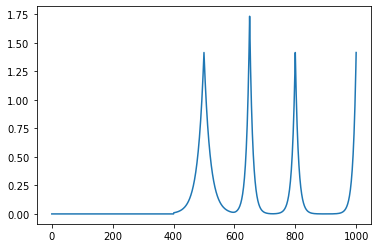

In [97]:
q1c = 2
q2c = 2
q3c = 3
tau1 = 10
tau2 = 5
tau3 = 5



q1 =  np.array([1 if (400<i)and(i<5000) else 0 for i in range(N+1)])
q2 = np.array([q1c*(math.e**(-abs(i-middle)/tau1)) for  i in range(len(ref_traj))])
q3 = q1*q2

q4 = np.array([1 if (600<i)and(i<5000) else 0 for i in range(N+1)])
q5 = np.array([q2c*(math.e**(-abs(i-N)/tau2)) for  i in range(len(ref_traj))])
q6 =  q5*q4

q7 = np.array([1 if (700<i)and(i<900) else 0 for i in range(N+1)])
q8 = np.array([q2c*(math.e**(-abs(i-800)/tau3)) for  i in range(len(ref_traj))])
q9 =  q7*q8

q10 = np.array([1 if (550<i)and(i<800) else 0 for i in range(N+1)])
q11 = np.array([q3c*(math.e**(-abs(i-650)/tau3)) for  i in range(len(ref_traj))])
q12 =  q10*q11


q = q3+q6 +q9 +q12





weight_mats = [100*np.diag([10,0,10,0,10*q[i],0.1]) for  i in range(len(ref_traj))]
# weight_mats2 = [100*np.diag([10,0,10,0,q2,0])*(math.e**(-abs(i-N)/tau2)) for  i in range(len(ref_traj))]
# weight_mats = [weight_mats[i]+weight_mats2[i] for i in range(len(weight_mats2))]
plt.figure()
plt.plot(np.sqrt(q))

In [98]:

ilqr_traj_ctrl = iLQR_Track_Controller(R=.01, dt=0.01)
ilqr_traj_ctrl.build_iLQR_tracking(ref_traj, weight_mats, robot)
x0 = ref_traj[0]
res = ilqr_traj_ctrl.get_rule(x0, u_init,n_itrs = 200, tol = 1)
z0 = x0
z0[-2:] = [0.0]
x_array = res["x_array_opt"]
u_array = res["u_array_opt"]
k_array = res["k_array_opt"]
K_array = res["K_array_opt"]
def ilqr_controller(state,i):
    ut = K_array[i].dot(state-x_array[i]) + k_array[i] + u_array[i]
    return ut.T
t, state, u = robot.simulate(z0,ilqr_controller, horizon_length, disturbance = False)



Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Iteration (3,):	J = 2077969.429;	norm_k = 58.427;	reg = 0.000
Reject the control perturbation. Increase the regularization term.
Iteration (5,):	J = 1285219.124;	norm_k = 12.263;	reg = 0.000
Reject the control perturbation. Increase the regularization term.
Iteration (7,):	J = 1122712.462;	norm_k = 10.111;	reg = 0.000
Reject the control perturbation. Increase the regularization term.
Reject the control perturbation. Increase the regularization term.
Iteration (10,):	J = 1072004.644;	norm_k = 1.913;	reg = 1.000
Iteration (11,):	J = 937825.015;	norm_k = 8.612;	reg = 0.000
Reject the control perturbation. Increase the regularization term.
Iteration (13,):	J = 686824.609;	norm_k = 8.031;	reg = 0.000
Reject the control perturbation. Increase the regularization term.
Iteration (15,):	J = 527163.122;	norm_k = 6.198;	reg = 0.000
Reject the control perturbation. 

Text(0.5, 0, 'Time [s]')

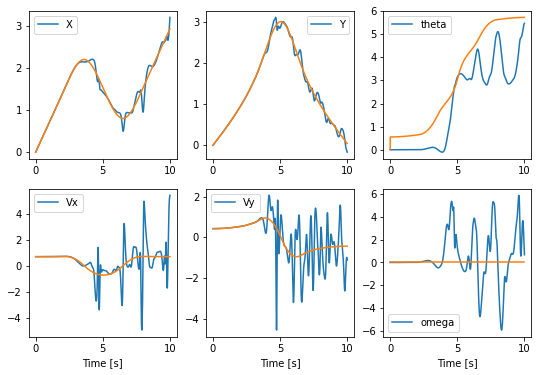

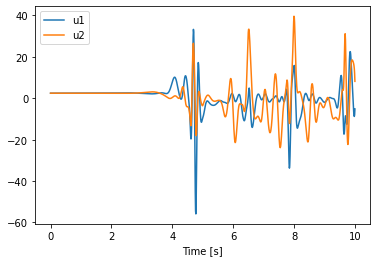

In [99]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')



In [100]:
robot.animate_robot(state,u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAaCttZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA25ZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAI14KuH+4x2xPbAAAArgAVwJEflNQL71nT4ADkMV
VPbRK84RdyqRUb6gRRR3eFQvVE+KTOH603JMImy4IeauYGfkC5QJLIc84ErblKTJbTqwzR4Yl3kc
jYnKfKjcI37bKL3OEZMXCcYw2mayGHGQhOtp/ofbg//2++sGGRgJage3e3p1cJ4vwELvqcBAznSW
jm9uE69bPcEEqxzH/ygnG5ls/l7oCONpPHi5MF+btferr8Bzmr6tMzJGQf/zh/iGvAzUPS2Gge92
f2xwHFqeeFXI1n5KJ0tJ3eSmef4m5qwxaNgSab2HNe5btwLwx92McX3eP0RxBpxxpjJYeHX2fhCx
6NF1/mPKgHKDE5yDkR4/ZXnRRGJsCS9Ud60KAADA1alT3Z1if6BRcU4T/UKdfgRHDzb9uRI52rCA
BHmjMyYPS/ul5ocmIh2a74Daim5eLYzKhHb7uv5neNAd7QaqmcVGhanNqEyjnepb95COF2Iumrkx
fp30fE8K+fRt/hSKaTgFjBT6A2ex3Z4tD6bA3wF3afxcauptd55HfF5OKBVNNQpUdmNKeUfKyh2H
XEWveKXQmgG+/9OiN16GftaTnsmuPRSHMC/2MlqookKz3XSQtCwrirCdTkXjhm+Rp4nAOlFPyx/e
j8N8LOik/QJ9I2E8GYSxy0+oo/BIACd4EjwNRK3JKMYyK4/Odm3L8pQQPCMT8Sxb0/vvCn2rz8Ou
/s8P4PVPz2IFiQwZdgPWdD1i4UAaXWg8k3GJYyZfRpXU1kE0AfRb+wBUB8CGZ5eFtCdNSgAAM54P
j3eroPSB0BUVSO7Xa5qYz3APg8bVwMDrn9eggz4Kc+OGSHIrhb72ZNBBvbTwCBbVmUEYqt6iq1Sa
BMBTJhG4Bxh5KEif0vM2JtNBWUg6x1VVM7BaSpkTyb2U3Wsu2rk7vw46UZcSun/xYlnaakh6c9ep
mP/8ATIeSnxfL9tBVkjWpkjXrlf0rNV6L5IY/wM4ERwcMpBbl+cOAF83E62y+Iz0AxXeI75KTvN7
8mR51fnsUuIHZIJIVk+LIlzuSclD3mv77+g4d41ptRbbZu/kyGIRqF/70VwMacAeAIv0XZ/W9lWx
ysKFt4yPviULqLjur3Od8YYoFAJMo+faP+Jn8k7FGoHe6nAD0szhfYAAABNQ5TIZ+I6p27DTFBYR
JwmsD/JDqBUHq7SnRYV/95gu7HCfCp+4uYQqfk81Z05Y8WGyZCn4yPCnGHjwkkH/71SNfFPAYozf
1Ps3cqw0bcEpH/Z+Q8TUS49hSLub3Olrlc0+iScFfhemNAp6Y+IRoS0NKsWOCJNlg0HP1WmqMVv4
wB2TCBFG7d7GP+fIG+fbk8QrhwuISBh/c0efhssjk9enRJBi8XPrFK/1wW7Ea9r3hXFNfqWlRrRB
W7pTSRBZYXS1qMyYM60rkKGdLGPl7o4BUKzwfCV3qRv4UccInHFEDIirzWsFQ/yIa/mNZ5SGZ/JC
0sbXDe3eY+/oc0xgp2ThLL3UMT237yi4TLrSKq/pQcq05Zr6+iQuZLYAAYSHIMfuA9HJ2nXgAXoc
f43+u8INXCxXVHd8htwXNqw0xabDRDMGp9DOB2t39kqFl9sPAJZQE/9mJoF4VCEO1cJzSd1YXDAz
ibcZ9E7XOXBAd43n35ZHlrsmqH0LSF4JLoVlCY1PG85RacdSw7u+aqAnxjwh+X2TFMKzo64BTzLr
mYaW1ytEydVZTNBHPr7JQtJceHrk3S1Nxu7kjA8cokulRMdsZHdIyj7JnNg252M3COyiUThf4IqI
Sf65+75uBR9Tgq/cE/jWdKa3pCbaCM1Xd4gVZ4kUhpMbxZk5LOHRrDegJSTJqi16WLqC72IRTTm8
B3zXa8A5vBOc0AVHLchouEbKsG/6LltBUojQr1DhcGQjk00noTRP3txaMJj6JjUH2M/V4PaN7nuG
lsRxy2Tefk6UD+/vvqLcgWhYEDSkkz6vlD8mI90euxzM/wUvxef1P+6aGMZORx2iNFqfz9UDeQzk
dDYHssBYG0mQPEP19na4vn6ZSk3oaYGoVT5Qc5zX/B/H336ok9yfJwyTL6vQKNpbsdjZUtfLP7h4
gR/YXlFPKBupdSl4ZsVezU08mSA3Qxm9DcpEC6FaWpQV8vqpIc2WpJL7hIxfQnz5tIoZ+UFX/DbV
AACj+jjKst7hgAAAva3pICJzd5KT63xwgOyWOAsZSD/MBO47hpVp3SYYP6YG3XdV2wq+fiPKB9BK
pNSTJtrDF1vNZXHMg+2qMNTGuwJv1INnn+xQNK7OWOhx7joMjVL0EYW9TSbKrd+nCqOia+9RDFrp
LPf0honYk+dReZdXZMUPtSvzG3YGJg14WPAK9Q6/onvQo9JMeppbdA4cRY68lvbMNY9wGn8H/5gk
uYnX20LRbT0YOSevc1AhBdQV3wA95XLtlF/OBUBnjCx088ngqG2OWts77g97fYQ19BKtk01DDgPO
xKLkVMasg6TrxcnV22HDdJCPdEMD7BvpKny7SeWd4PeL1x76soiq3Ll0AAADAAADAAStzp2HWZAG
YPlhhFBEy2kKrNvf7Aivo8fq01Aee93lUr7yMqYfklDfRefY/E9tjBCVi8ahKixQzbSYDhVYVl5X
5v5VBtT6zIgxPsnlmUU1WTo6TG0RVc2bUQzCqM7IuWajgAAA9F+OyooToIHDx2zdKtHEHl+K7ByA
OI3lsX4v6of6k7RhDvMhC+QJuav1QN5DOR0ThnaYNLzw/kgNrMDcnXjJgRgPOFFs4631Oo/3NcOV
NVIZa4T66v7jf+xmt1kiFSTE8ZRintfFR8Cwho31Mn1oeKa2aQB6HiDFQCkVtn4kHGsQAAADAAGJ
G/3bbIHWvlLizC6hhTmTX